In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal

import glob
import pickle

from utils import *
import collections

In [2]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

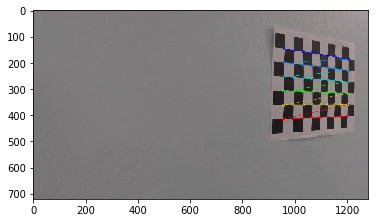

In [3]:
for image in images:

    # Read in image
    img = cv2.imread(image)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

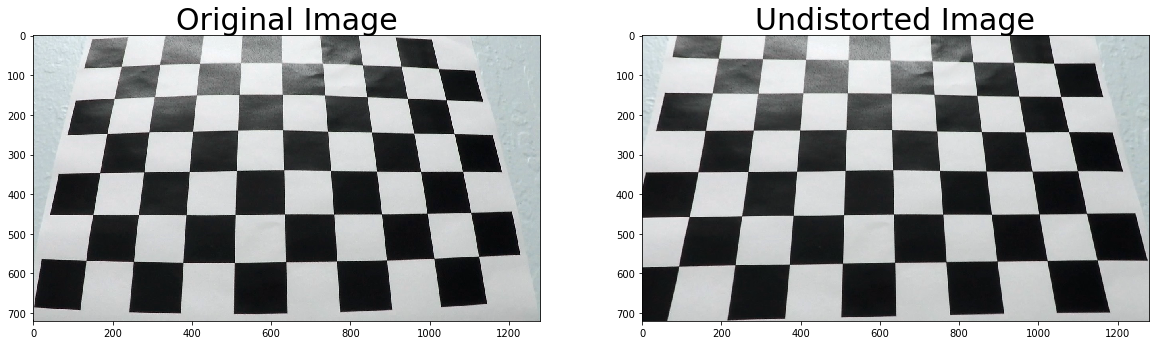

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
# Save the camera calibration result.
save = {
    "mtx" : mtx,
    "dist" : dist   
}

pickle.dump( save, open( "camera_calibration.p", "wb" ) )

Pipeline (single images)
1. Has the distortion correction been correctly applied to each image?

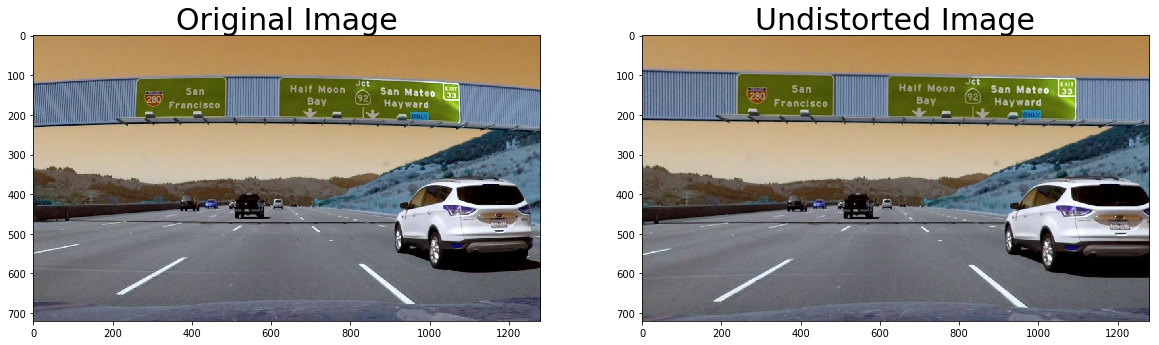

In [6]:
raw = cv2.imread("test_images/signs_vehicles_xygrad.png")
#raw = cv2.imread("test_images/test5.jpg")

#raw = cv2.imread("1050.jpg")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

2. Has a binary image been created using color transforms, gradients or other methods?

In [7]:
# Parameters
imshape = raw.shape

height = raw.shape[0]
#    offset = 50
#    offset_height = height - offset
half_frame = raw.shape[1] // 2
steps = 6
pixels_per_step = height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40

blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

In [8]:
#s_thresh=(150, 255)
#sx_thresh=(40, 100)

s_thresh=(150, 255)
sx_thresh=(40, 100)
sy_thresh=(20, 100)
l_thresh = (100,255)


combined_binary, color_binary = convert_binary(image, s_thresh=s_thresh, sx_thresh=sx_thresh, 
                                                                sy_thresh=None, l_thresh=l_thresh)

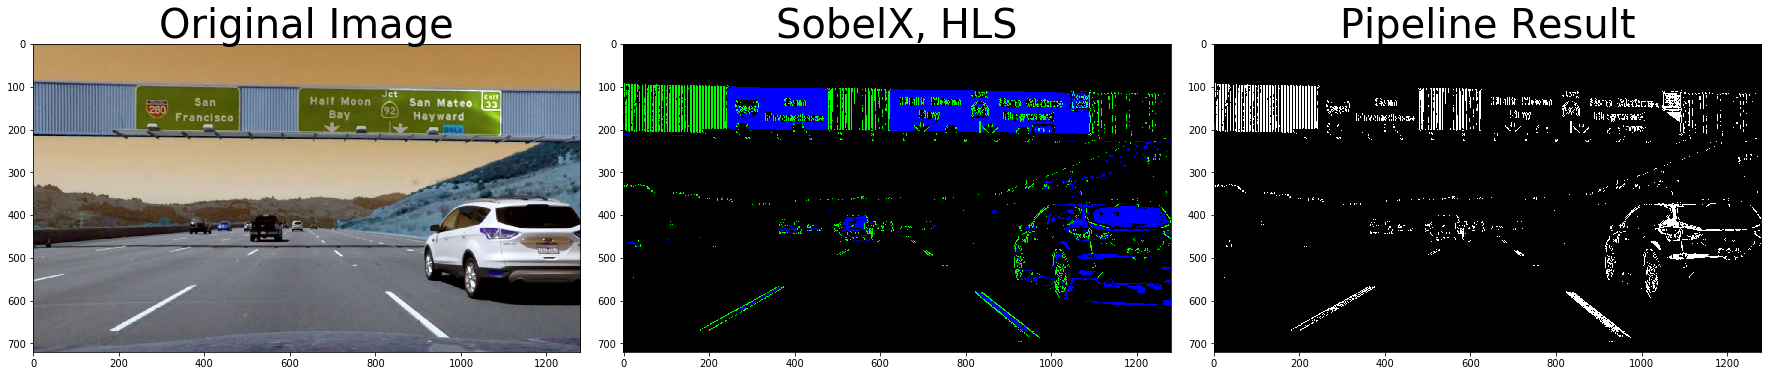

In [9]:
#combined_binary,b = convert_binary_test(image)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow( color_binary)
ax2.set_title('SobelX, HLS', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax3.imshow(combined_binary, cmap="gray")
ax3.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
src = np.float32([
    [120, image.shape[0]],
    [image.shape[1]/2 - 60, image.shape[0]-image.shape[0]/2+110],
    [image.shape[1]/2 + 60, image.shape[0]-image.shape[0]/2+110],
    [image.shape[1] - 120, image.shape[0]]
    ])


dst = np.float32([
    [150,image.shape[0]],
     [150 + 80,0],
     [image.shape[1] - 150 - 80,0],
     [image.shape[1] - 150,image.shape[0]]
    ])    
    


M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


print(image.shape)
print(image.shape[0])

print(src)
print(dst)

(720, 1280, 3)
720
[[  120.   720.]
 [  580.   470.]
 [  700.   470.]
 [ 1160.   720.]]
[[  150.   720.]
 [  230.     0.]
 [ 1050.     0.]
 [ 1130.   720.]]


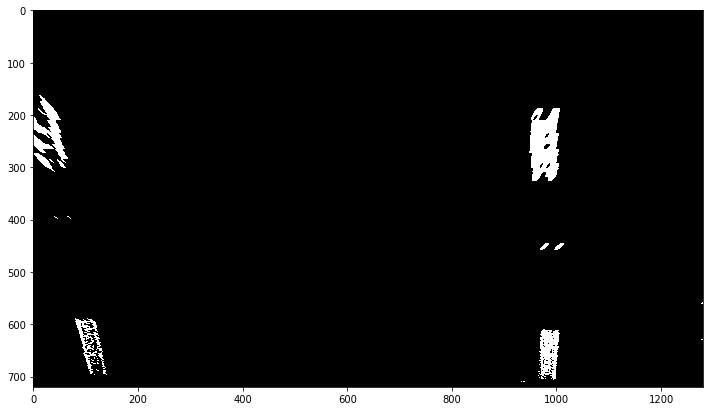

In [11]:
# Warp onto birds-eye-view
# Previous region-of-interest mask's function is absorbed by the warp
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.rcParams["figure.figsize"] = (12,9)
plt.imshow(warped, cmap="gray")

Have lane line pixels been identified in the rectified image and fit with a polynomial?

In [12]:
# Histogram and get pixels in window

leftx, lefty, rightx, righty, histogram = histogram_pixels(warped, horizontal_offset=horizontal_offset, steps=6,window_radius=200)

print(len(histogram))
print(len(leftx))

6
3187


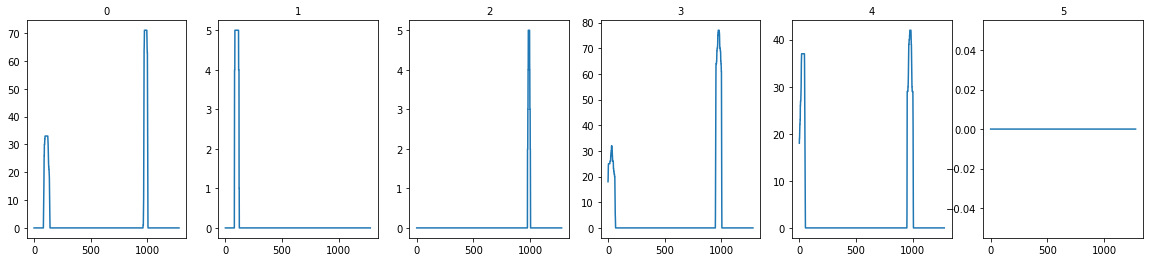

In [13]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20,4))
#ax1.imshow(raw)
ax1.plot(histogram[0])
ax1.set_title('0', fontsize=10)
#ax2.imshow(image)
ax2.plot(histogram[1])
ax2.set_title('1', fontsize=10)

ax3.plot(histogram[2])
ax3.set_title('2', fontsize=10)

ax4.plot(histogram[3])
ax4.set_title('3', fontsize=10)

ax5.plot(histogram[4])
ax5.set_title('4', fontsize=10)

ax6.plot(histogram[5])
ax6.set_title('5', fontsize=10)

left_fit: [  97.40875801   97.90677194   98.65202153 ...,  108.62407075  109.57569798
  108.14684009]
left_fit: 3187
Left coeffs: [ -1.18086782e-04   3.88349368e-01  -9.03622351e+01]
righty[0]: , 709.0 , rightx[0]:  932
Right coeffs:  [  3.17039644e-05  -8.33204615e-03   9.76910931e+02]


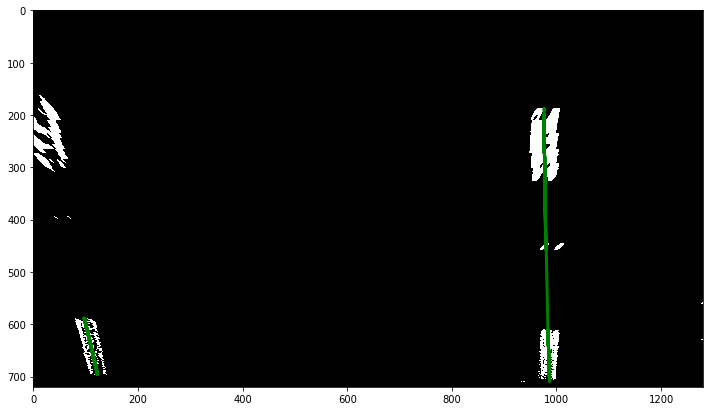

In [14]:
# Fit a second order polynomial to each fake lane line
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("left_fit:", left_fit)
print("left_fit:", len(left_fit))

print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)

# Plot data

plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

In [15]:
  """Returns x value for poly given a y-value.
    Note here x = Ay^2 + By + C."""

"""
def lane_poly_test(yval, poly_coeffs):
  
    
    print("lane_poly is called")
    
    return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]

def draw_poly_test(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img
    """

'\ndef lane_poly_test(yval, poly_coeffs):\n\n  \n  print("lane_poly is called")\n  \n  return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]\n\ndef draw_poly_test(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):\n  img_height = img.shape[0]\n  pixels_per_step = img_height // steps\n\n  for i in range(steps):\n      start = i * pixels_per_step\n      end = start + pixels_per_step\n\n      start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)\n      end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)\n\n      if dashed == False or i % 2 == 1:\n          img = cv2.line(img, end_point, start_point, color, thickness)\n\n  return img\n  '

Left coeffs:  [ -1.18086782e-04   3.88349368e-01  -9.03622351e+01]
Right coeffs:  [  3.17039644e-05  -8.33204615e-03   9.76910931e+02]
(720, 1280)


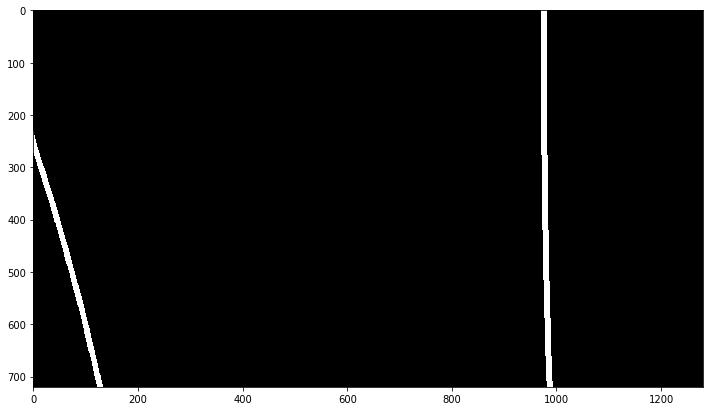

In [16]:
print("Left coeffs: ", left_coeffs)
print("Right coeffs: ", right_coeffs)
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")
print(polyfit_drawn.shape)

In [17]:
"""
def evaluate_poly_test(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]
"""

'\ndef evaluate_poly_test(indep, poly_coeffs):\n    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]\n'

In [18]:
def cal_curverad(ploty_left, leftx, ploty_right, rightx, y_eval ):
    
    y_eval = y_eval

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/850 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty_left*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty_right*ym_per_pix, rightx*xm_per_pix, 2)
    
    print('left_fit_cr')
    print(left_fit_cr)
    
    print('right_fit_cr')
    print(right_fit_cr)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('left' ,left_curverad, 'm, right', right_curverad, 'm')
    
    return left_curverad, right_curverad

In [19]:
def highlight_lane_line_area_test(mask_template, left_poly, right_poly, start_y=0, end_y =720):
    area_mask = mask_template
    for y in range(start_y, end_y):
        left = evaluate_poly(y, left_poly)
        right = evaluate_poly(y, right_poly)
        area_mask[y][int(left):int(right)] = 1

    return area_mask

<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280)
255.0


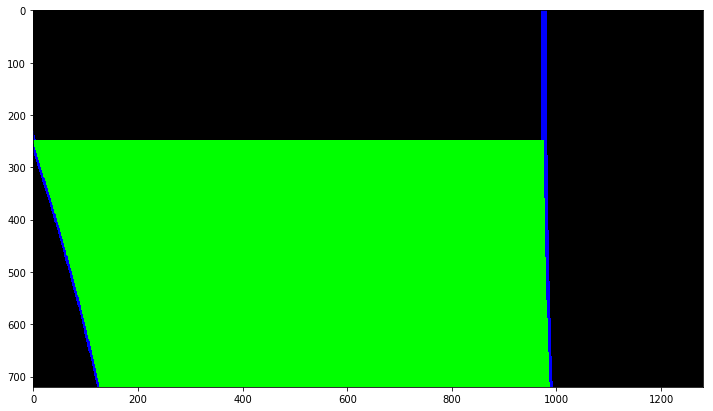

In [20]:
trace = colour_canvas
print(type(trace))
print(trace.shape)
#print(trace)
print(type(polyfit_drawn))
print(polyfit_drawn.shape)
print(np.max(polyfit_drawn))
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In [21]:
# Determine curvature of the lane
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
#y_eval = 500
y_eval = imshape[0]
print('y_eval is %d' % y_eval)

"""
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
"""


print('lefty')
print(lefty)
print(type(lefty))
print(len(lefty))
print('leftx')
print(leftx)
print(len(leftx))
print(type(leftx))
left_curverad, right_curverad = cal_curverad(lefty, leftx, righty, rightx, y_eval)


curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

print("center: ", centre, "pixels")

y_eval is 720
lefty
[ 589.  591.  594. ...,  635.  639.  633.]
<class 'numpy.ndarray'>
3187
leftx
[ 80  80  80 ..., 128 128 129]
3187
<class 'numpy.ndarray'>
left_fit_cr
[ -2.96078294e-04   4.05710869e-02  -3.93341494e-01]
right_fit_cr
[  7.94911635e-05  -8.70453763e-04   4.25243582e+00]
left 1690.06022979 m, right 6290.15074951 m
center:  -397.793927144 pixels


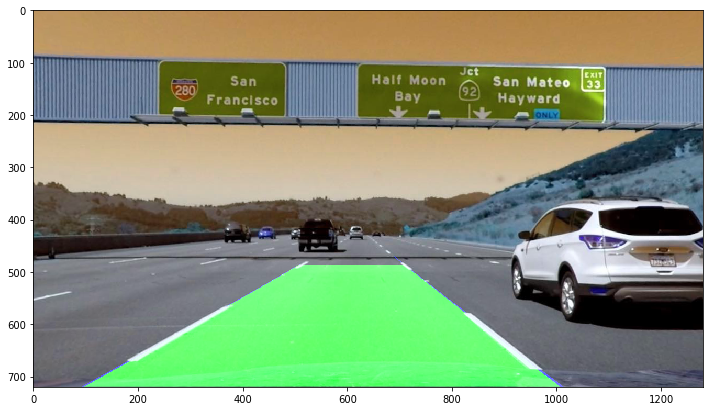

In [22]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to colour
combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img)

In [23]:
def add_figures_to_image_test(img, curvature, vehicle_position, min_curvature, frame_no, left_coeffs=(0,0,0), 
                              right_coeffs=(0,0,0)):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    """
    # Convert from pixels to meters
    vehicle_position = vehicle_position / 12800 * 3.7
    curvature = curvature / 128 * 37 
    min_curvature = min_curvature / 128 * 37 
    """
    
    vehicle_position = vehicle_position / 12800 * 3.7
    curvature = curvature 
    min_curvature = min_curvature 

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "left" if vehicle_position < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    cv2.putText(img, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Left poly coefficients = %.3f %.3f %.3f' % (left_coeffs[0], left_coeffs[1], left_coeffs[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Right poly coefficients = %.3f %.3f %.3f' % (right_coeffs[0], right_coeffs[1], right_coeffs[2]), (50, 250), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'frame no = %d' % frame_no, (50, 300), 
                    font, 1, (255, 255, 255), 2)

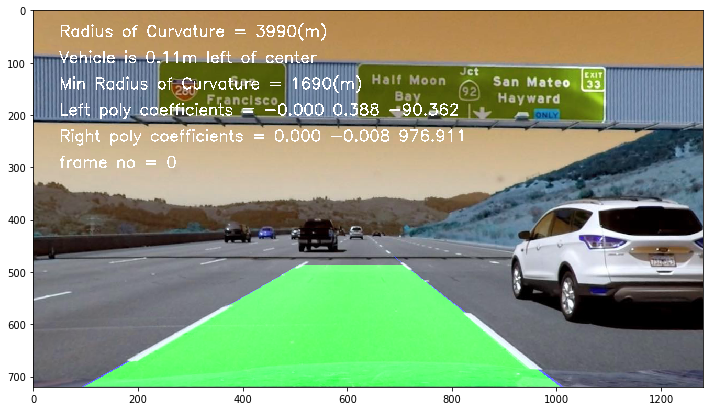

In [24]:
add_figures_to_image_test(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     frame_no = 0,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)

plt.rcParams["figure.figsize"] = (12,9)
plt.imshow(combined_img)

In [25]:
def fit_second_order_poly_test(indep, dep, return_coeffs=False):
    
    print("indep")
    print(indep)
    
    fit = np.polyfit(indep, dep, 2)
    
    bottom = fit[0] * 720 ** 2 +  fit[1] * 720 + fit[2]
    
    print(bottom)
    
    
    fitdep = fit[0]*indep**2 + fit[1]*indep + fit[2]
    if return_coeffs == True:
        return fitdep, fit, bottom
    else:
        return fitdep, bottom

In [26]:
with open("camera_calibration.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

prev_left_coeffs = None
prev_right_coeffs = None

frame_no = -1



def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    global frame_no
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
        
    src = np.float32([
    [120, imshape[0]],
    [imshape[1]/2 - 60, imshape[0]-imshape[0]/2+110],
    [imshape[1]/2 + 60, imshape[0]-imshape[0]/2+110],
    [imshape[1] - 120, imshape[0]]
    ])

    dst = np.float32([
    [150,imshape[0]],
    [150 + 80,0],
    [imshape[1] - 150 - 80,0],
    [imshape[1] - 150,imshape[0]]
    ])       
    
    
   

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    imshape = raw.shape

    height = raw.shape[0]
#    offset = 50
#    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = height / steps
    window_radius = 200
    medianfilt_kernel_size = 51
    horizontal_offset = 40





    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
#    combined = apply_thresholds(image)

    ## Option II

    have_fit = False
#    curvature_checked = False

    s_thresh=(150, 255)
    sx_thresh=(40, 100)
    sy_thresh=(20, 100)
    l_thresh = (100,255)

    while have_fit == False:
#        combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
        combined_binary , color_binary  = convert_binary(image, s_thresh=s_thresh, sx_thresh=sx_thresh, 
                                                                sy_thresh=None, l_thresh=l_thresh)
    #    plt.imshow(combined_binary, cmap="gray")

        # Plotting thresholded images
        """
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Option 1')
        ax1.imshow(combined, cmap="gray")

        ax2.set_title('Option 2: Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        """

        # Warp onto birds-eye-view
        # Previous region-of-interest mask's function is absorbed by the warp
        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
        # plt.imshow(warped, cmap="gray")

        # Histogram and get pixels in window

#        leftx, lefty, rightx, righty, histograms = histogram_pixels(warped, horizontal_offset=40)
        leftx, lefty, rightx, righty, histograms = histogram_pixels(warped, horizontal_offset=horizontal_offset, steps=6,window_radius=200)

        
        print('leftx')
        print(leftx)
        print(type(leftx))
        print('lefty')
        print(lefty)
        print(type(lefty))

        plt.imshow(warped, cmap="gray")

        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
            
#        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)

    left_fit, left_coeffs, left_bottom = fit_second_order_poly_test(lefty, leftx, return_coeffs=True)
    print("Left coeffs:", left_coeffs)
    print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
    right_fit, right_coeffs, right_bottom = fit_second_order_poly_test(righty, rightx, return_coeffs=True)
    print("Right coeffs: ", right_coeffs)
    
  

    # Plot data
    """
    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")
    """

    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    # y_eval = 500
    y_eval = imshape[0]
    
    """
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                    /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     /(2 * right_coeffs[0]))
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)
    """
    
    left_curverad, right_curverad = cal_curverad(lefty, leftx, righty, rightx, y_eval)
    print('leftx debugging')
    print(leftx)
    print(len(leftx))
    print('lefty debugging')
    print(lefty)
    print(len(lefty))
    
    
    curvature = (left_curverad + right_curverad) / 2
    min_curverad = min(left_curverad, right_curverad)
    
    if((right_bottom - left_bottom) < 700):
        left_coeffs = prev_left_coeffs
        right_coeffs = prev_right_coeffs
        
    prev_left_coeffs = left_coeffs
    prev_right_coeffs = right_coeffs

    
    # Det vehicle position wrt centre
    centre = center(719, left_coeffs, right_coeffs)
        
    ## 7. Warp the detected lane boundaries back onto the original image.

    print("Left coeffs: ", left_coeffs)
    print("Right fit: ", right_coeffs)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
#    plt.imshow(polyfit_drawn, cmap="gray")
#    plt.imshow(warped)

    # Convert to colour and highlight lane line area
    trace = colour_canvas
    trace[polyfit_drawn > 1] = [0,0,255]
    print("polyfit shape: ", polyfit_drawn.shape)
    area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]
    # plt.imshow(trace)
    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(trace)

    combined_img = cv2.add(lane_lines, image)
    frame_no = frame_no + 1
    
   
        
    
    add_figures_to_image_test(combined_img, curvature=curvature, 
                         vehicle_position=centre, 
                         min_curvature=min_curverad,
                         frame_no = frame_no,
                         left_coeffs=left_coeffs,
                         right_coeffs=right_coeffs)
    """
    if(frame_no == 1050):
        filename =  str(frame_no) + '.jpg'
        cv2.imwrite( filename, raw )
        
    if(frame_no < 90 and frame_no > 70):
        filename =  str(frame_no) + '.jpg'
        cv2.imwrite( filename, raw )
    """      
    
    plt.imshow(combined_img)
#    return combined_img,warped,combined_binary 
    return combined_img

#combined_img,warped, combined_binary  = image_pipeline("test_images/signs_vehicles_xygrad.png", filepath=True)

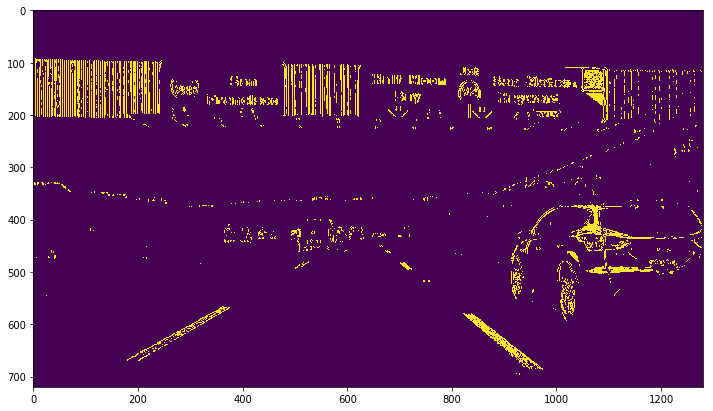

In [27]:
plt.imshow(combined_binary)

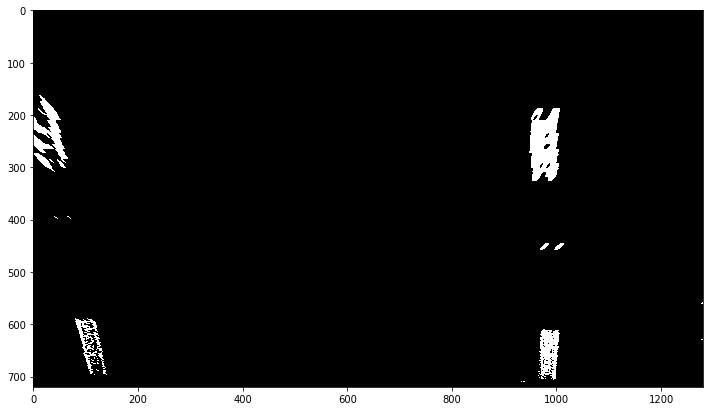

In [28]:
plt.imshow(warped, cmap="gray")

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
video_dir = "../../../CarND-Advanced-Lane-Lines/project_video.mp4"

output = 'project_output_colour.mp4'
clip1 = VideoFileClip(video_dir)
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

leftx
[260 260 261 ..., 247 248 248]
<class 'numpy.ndarray'>
lefty
[ 565.  566.  560. ...,  159.  159.  160.]
<class 'numpy.ndarray'>
indep
[ 565.  566.  560. ...,  159.  159.  160.]
305.801298122
Left coeffs: [ -1.51124220e-04   3.46495051e-01   1.34667657e+02]
righty[0]: , 560.0 , rightx[0]:  1153
indep
[ 560.  592.  560. ...,  102.  103.  118.]
1170.69140612
Right coeffs:  [ -1.52421590e-04   1.32185180e-01   1.15453343e+03]
left_fit_cr
[ -3.78912868e-04   3.61985418e-02   5.86200391e-01]
right_fit_cr
[ -3.82165755e-04   1.38094635e-02   5.02561610e+00]
left 1319.92339865 m, right 1308.49606902 m
leftx debugging
[260 260 261 ..., 247 248 248]
40835
lefty debugging
[ 565.  566.  560. ...,  159.  159.  160.]
40835
Left coeffs:  [ -1.51124220e-04   3.46495051e-01   1.34667657e+02]
Right fit:  [ -1.52421590e-04   1.32185180e-01   1.15453343e+03]
polyfit shape:  (720, 1280)
[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


  0%|          | 1/1261 [00:00<08:03,  2.60it/s]

leftx
[260 260 261 ..., 247 248 248]
<class 'numpy.ndarray'>
lefty
[ 565.  566.  560. ...,  159.  159.  160.]
<class 'numpy.ndarray'>
indep
[ 565.  566.  560. ...,  159.  159.  160.]
305.801298122
Left coeffs: [ -1.51124220e-04   3.46495051e-01   1.34667657e+02]
righty[0]: , 560.0 , rightx[0]:  1153
indep
[ 560.  592.  560. ...,  102.  103.  118.]
1170.69140612
Right coeffs:  [ -1.52421590e-04   1.32185180e-01   1.15453343e+03]
left_fit_cr
[ -3.78912868e-04   3.61985418e-02   5.86200391e-01]
right_fit_cr
[ -3.82165755e-04   1.38094635e-02   5.02561610e+00]
left 1319.92339865 m, right 1308.49606902 m
leftx debugging
[260 260 261 ..., 247 248 248]
40835
lefty debugging
[ 565.  566.  560. ...,  159.  159.  160.]
40835
Left coeffs:  [ -1.51124220e-04   3.46495051e-01   1.34667657e+02]
Right fit:  [ -1.52421590e-04   1.32185180e-01   1.15453343e+03]
polyfit shape:  (720, 1280)


  0%|          | 2/1261 [00:00<07:59,  2.62it/s]

leftx
[263 263 263 ..., 261 262 262]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  562. ...,  210.  209.  210.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  562. ...,  210.  209.  210.]
306.531944854
Left coeffs: [ -1.46160963e-04   3.38464755e-01   1.38607165e+02]
righty[0]: , 627.0 , rightx[0]:  1150
indep
[ 627.  560.  590. ...,  147.  148.  149.]
1171.31942367
Right coeffs:  [ -1.16860735e-04   1.09343047e-01   1.15317303e+03]
left_fit_cr
[ -3.66468522e-04   3.53596120e-02   6.03348834e-01]
right_fit_cr
[ -2.93004232e-04   1.14231324e-02   5.01969439e+00]
left 1364.73959925 m, right 1706.55703169 m
leftx debugging
[263 263 263 ..., 261 262 262]
40813
lefty debugging
[ 560.  561.  562. ...,  210.  209.  210.]
40813
Left coeffs:  [ -1.46160963e-04   3.38464755e-01   1.38607165e+02]
Right fit:  [ -1.16860735e-04   1.09343047e-01   1.15317303e+03]
polyfit shape:  (720, 1280)


  0%|          | 3/1261 [00:01<07:53,  2.66it/s]

leftx
[265 265 266 ..., 274 274 274]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  560. ...,  252.  253.  254.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  560. ...,  252.  253.  254.]
304.572400505
Left coeffs: [ -1.99625932e-04   3.83261290e-01   1.32110355e+02]
righty[0]: , 560.0 , rightx[0]:  1149
indep
[ 560.  562.  590. ...,  199.  200.  211.]
1176.65716322
Right coeffs:  [ -1.71670639e-05   3.80383565e-02   1.15816895e+03]
left_fit_cr
[ -5.00520925e-04   4.00395324e-02   5.75068604e-01]
right_fit_cr
[ -4.30428782e-05   3.97388948e-03   5.04144132e+00]
left 999.109329431 m, right 11616.3572787 m
leftx debugging
[265 265 266 ..., 274 274 274]
40159
lefty debugging
[ 560.  561.  560. ...,  252.  253.  254.]
40159
Left coeffs:  [ -1.99625932e-04   3.83261290e-01   1.32110355e+02]
Right fit:  [ -1.71670639e-05   3.80383565e-02   1.15816895e+03]
polyfit shape:  (720, 1280)


  0%|          | 4/1261 [00:01<07:46,  2.69it/s]

leftx
[267 267 268 ..., 281 281 282]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  560. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  560. ...,  278.  279.  279.]
306.275508655
Left coeffs: [ -2.06629380e-04   3.93098481e-01   1.30361273e+02]
righty[0]: , 590.0 , rightx[0]:  1147
indep
[ 590.  592.  623. ...,  244.  245.  246.]
1176.16628227
Right coeffs:  [  3.64419569e-05  -9.02946222e-03   1.16377598e+03]
left_fit_cr
[ -5.18080630e-04   4.10672295e-02   5.67454954e-01]
right_fit_cr
[  9.13707043e-05  -9.43313230e-04   5.06584840e+00]
left 965.245001104 m, right 5472.38259243 m
leftx debugging
[267 267 268 ..., 281 281 282]
40790
lefty debugging
[ 560.  561.  560. ...,  278.  279.  279.]
40790
Left coeffs:  [ -2.06629380e-04   3.93098481e-01   1.30361273e+02]
Right fit:  [  3.64419569e-05  -9.02946222e-03   1.16377598e+03]
polyfit shape:  (720, 1280)


  0%|          | 5/1261 [00:01<07:38,  2.74it/s]

leftx
[250 267 268 ..., 249 250 250]
<class 'numpy.ndarray'>
lefty
[ 643.  561.  561. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 643.  561.  561. ...,  279.  278.  279.]
305.498931864
Left coeffs: [ -2.42269599e-04   4.25642381e-01   1.24628978e+02]
righty[0]: , 621.0 , rightx[0]:  1146
indep
[ 621.  687.  620. ...,  244.  245.  246.]
1171.73874537
Right coeffs:  [ -8.36780850e-06   2.63695944e-02   1.15709051e+03]
left_fit_cr
[-0.00060744  0.04446711  0.54250261]
right_fit_cr
[ -2.09805570e-05   2.75484704e-03   5.03674692e+00]
left 823.204447321 m, right 23831.6684258 m
leftx debugging
[250 267 268 ..., 249 250 250]
38495
lefty debugging
[ 643.  561.  561. ...,  279.  278.  279.]
38495
Left coeffs:  [ -2.42269599e-04   4.25642381e-01   1.24628978e+02]
Right fit:  [ -8.36780850e-06   2.63695944e-02   1.15709051e+03]
polyfit shape:  (720, 1280)


  0%|          | 6/1261 [00:02<07:38,  2.74it/s]

leftx
[250 269 269 ..., 249 250 250]
<class 'numpy.ndarray'>
lefty
[ 643.  560.  561. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 643.  560.  561. ...,  279.  278.  279.]
309.238579918
Left coeffs: [ -2.31636829e-04   4.26588735e-01   1.22175223e+02]
righty[0]: , 651.0 , rightx[0]:  1145
indep
[ 651.  652.  653. ...,  265.  266.  244.]
1171.96951435
Right coeffs:  [  7.60422600e-05  -5.72627405e-02   1.17377838e+03]
left_fit_cr
[-0.00058078  0.04456598  0.53182156]
right_fit_cr
[  1.90660311e-04  -5.98227218e-03   5.10938824e+00]
left 861.030715435 m, right 2622.58219491 m
leftx debugging
[250 269 269 ..., 249 250 250]
39047
lefty debugging
[ 643.  560.  561. ...,  279.  278.  279.]
39047
Left coeffs:  [ -2.31636829e-04   4.26588735e-01   1.22175223e+02]
Right fit:  [  7.60422600e-05  -5.72627405e-02   1.17377838e+03]
polyfit shape:  (720, 1280)


  1%|          | 7/1261 [00:02<07:45,  2.69it/s]

leftx
[248 250 269 ..., 245 245 246]
<class 'numpy.ndarray'>
lefty
[ 642.  643.  561. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 642.  643.  561. ...,  278.  279.  279.]
311.730270929
Left coeffs: [ -2.18547725e-04   4.24212278e-01   1.19592571e+02]
righty[0]: , 682.0 , rightx[0]:  1146
indep
[ 682.  683.  681. ...,  364.  362.  363.]
1170.01009539
Right coeffs:  [  4.71305357e-05  -4.42892200e-02   1.17746586e+03]
left_fit_cr
[-0.00054796  0.04431771  0.52057943]
right_fit_cr
[  1.18170115e-04  -4.62692087e-03   5.12543964e+00]
left 912.648789818 m, right 4231.2267434 m
leftx debugging
[248 250 269 ..., 245 245 246]
38500
lefty debugging
[ 642.  643.  561. ...,  278.  279.  279.]
38500
Left coeffs:  [ -2.18547725e-04   4.24212278e-01   1.19592571e+02]
Right fit:  [  4.71305357e-05  -4.42892200e-02   1.17746586e+03]
polyfit shape:  (720, 1280)


  1%|          | 8/1261 [00:02<07:49,  2.67it/s]

leftx
[272 272 272 ..., 245 245 246]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  562. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  562. ...,  278.  279.  279.]
314.035652821
Left coeffs: [ -2.17468598e-04   4.23678680e-01   1.21722724e+02]
righty[0]: , 573.0 , rightx[0]:  1146
indep
[ 573.  573.  566. ...,  102.  103.  104.]
1166.80139142
Right coeffs:  [ -1.44509185e-04   1.63882007e-01   1.12371991e+03]
left_fit_cr
[-0.00054526  0.04426196  0.52985186]
right_fit_cr
[ -3.62327030e-04   1.71208497e-02   4.89148666e+00]
left 917.180924273 m, right 1380.012969 m
leftx debugging
[272 272 272 ..., 245 245 246]
37506
lefty debugging
[ 560.  561.  562. ...,  278.  279.  279.]
37506
Left coeffs:  [ -2.17468598e-04   4.23678680e-01   1.21722724e+02]
Right fit:  [ -1.44509185e-04   1.63882007e-01   1.12371991e+03]
polyfit shape:  (720, 1280)


  1%|          | 9/1261 [00:03<07:48,  2.67it/s]

leftx
[269 270 270 ..., 240 241 241]
<class 'numpy.ndarray'>
lefty
[ 561.  561.  562. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 561.  561.  562. ...,  279.  278.  279.]
314.198778196
Left coeffs: [ -2.07077215e-04   4.24724794e-01   1.15745755e+02]
righty[0]: , 448.0 , rightx[0]:  1143
indep
[ 448.  449.  453. ...,  132.  133.  134.]
1159.73881582
Right coeffs:  [ -1.86820439e-04   1.77381063e-01   1.12887217e+03]
left_fit_cr
[-0.0005192   0.04437125  0.50383446]
right_fit_cr
[ -4.68413788e-04   1.85311040e-02   4.91391414e+00]
left 963.265999815 m, right 1067.57904302 m
leftx debugging
[269 270 270 ..., 240 241 241]
39535
lefty debugging
[ 561.  561.  562. ...,  279.  278.  279.]
39535
Left coeffs:  [ -2.07077215e-04   4.24724794e-01   1.15745755e+02]
Right fit:  [ -1.86820439e-04   1.77381063e-01   1.12887217e+03]
polyfit shape:  (720, 1280)


  1%|          | 10/1261 [00:03<08:01,  2.60it/s]

leftx
[269 269 269 ..., 236 236 237]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  567. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  567. ...,  278.  279.  279.]
313.117491948
Left coeffs: [ -2.20004807e-04   4.43654909e-01   1.07736449e+02]
righty[0]: , 633.0 , rightx[0]:  1149
indep
[ 633.  627.  633. ...,  176.  177.  174.]
1163.73884532
Right coeffs:  [ -1.81529247e-04   1.84169772e-01   1.12524137e+03]
left_fit_cr
[-0.00055162  0.04634889  0.46897043]
right_fit_cr
[ -4.55147212e-04   1.92403244e-02   4.89810950e+00]
left 906.665194064 m, right 1098.65294818 m
leftx debugging
[269 269 269 ..., 236 236 237]
40659
lefty debugging
[ 560.  561.  567. ...,  278.  279.  279.]
40659
Left coeffs:  [ -2.20004807e-04   4.43654909e-01   1.07736449e+02]
Right fit:  [ -1.81529247e-04   1.84169772e-01   1.12524137e+03]
polyfit shape:  (720, 1280)


  1%|          | 11/1261 [00:04<08:07,  2.57it/s]

leftx
[269 269 270 ..., 236 236 237]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  560. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  560. ...,  278.  279.  279.]
314.206587716
Left coeffs: [ -2.19744429e-04   4.49252426e-01   1.04660353e+02]
righty[0]: , 664.0 , rightx[0]:  1148
indep
[ 664.  657.  664. ...,  211.  212.  213.]
1154.0821794
Right coeffs:  [ -3.36322992e-04   3.37576685e-01   1.08537681e+03]
left_fit_cr
[-0.00055096  0.04693367  0.45558036]
right_fit_cr
[ -8.43260661e-04   3.52668349e-02   4.72458139e+00]
left 907.76255488 m, right 593.145468454 m
leftx debugging
[269 269 270 ..., 236 236 237]
40628
lefty debugging
[ 560.  561.  560. ...,  278.  279.  279.]
40628
Left coeffs:  [ -2.19744429e-04   4.49252426e-01   1.04660353e+02]
Right fit:  [ -3.36322992e-04   3.37576685e-01   1.08537681e+03]
polyfit shape:  (720, 1280)


  1%|          | 12/1261 [00:04<08:00,  2.60it/s]

leftx
[263 264 264 ..., 227 227 227]
<class 'numpy.ndarray'>
lefty
[ 563.  563.  564. ...,  277.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 563.  563.  564. ...,  277.  278.  279.]
311.849552384
Left coeffs: [ -2.10963865e-04   4.53652616e-01   9.45833369e+01]
righty[0]: , 687.0 , rightx[0]:  1151
indep
[ 687.  686.  687. ...,  235.  236.  234.]
1169.08113494
Right coeffs:  [ -2.34093898e-04   2.47340789e-01   1.11235004e+03]
left_fit_cr
[-0.00052895  0.04739336  0.4117157 ]
right_fit_cr
[ -5.86942253e-04   2.58398377e-02   4.84199431e+00]
left 945.619268736 m, right 851.984911417 m
leftx debugging
[263 264 264 ..., 227 227 227]
40176
lefty debugging
[ 563.  563.  564. ...,  277.  278.  279.]
40176
Left coeffs:  [ -2.10963865e-04   4.53652616e-01   9.45833369e+01]
Right fit:  [ -2.34093898e-04   2.47340789e-01   1.11235004e+03]
polyfit shape:  (720, 1280)


  1%|          | 13/1261 [00:04<08:20,  2.49it/s]

leftx
[263 263 263 ..., 226 226 226]
<class 'numpy.ndarray'>
lefty
[ 561.  562.  563. ...,  271.  272.  273.]
<class 'numpy.ndarray'>
indep
[ 561.  562.  563. ...,  271.  272.  273.]
312.940031636
Left coeffs: [ -2.18452853e-04   4.66540258e-01   9.02770050e+01]
righty[0]: , 470.0 , rightx[0]:  1145
indep
[ 470.  469.  470. ...,  102.  103.  104.]
1175.31023482
Right coeffs:  [ -1.63120760e-04   2.03129199e-01   1.11361901e+03]
left_fit_cr
[-0.00054773  0.04873974  0.39297049]
right_fit_cr
[ -4.08991722e-04   2.12210269e-02   4.84751806e+00]
left 913.211094899 m, right 1222.53882528 m
leftx debugging
[263 263 263 ..., 226 226 226]
39262
lefty debugging
[ 561.  562.  563. ...,  271.  272.  273.]
39262
Left coeffs:  [ -2.18452853e-04   4.66540258e-01   9.02770050e+01]
Right fit:  [ -1.63120760e-04   2.03129199e-01   1.11361901e+03]
polyfit shape:  (720, 1280)


  1%|          | 14/1261 [00:05<08:18,  2.50it/s]

leftx
[259 260 263 ..., 231 231 231]
<class 'numpy.ndarray'>
lefty
[ 669.  669.  560. ...,  184.  185.  186.]
<class 'numpy.ndarray'>
indep
[ 669.  669.  560. ...,  184.  185.  186.]
312.643407766
Left coeffs: [ -2.22908592e-04   4.74293011e-01   8.67082536e+01]
righty[0]: , 569.0 , rightx[0]:  1150
indep
[ 569.  571.  607. ...,  148.  149.  150.]
1178.67747688
Right coeffs:  [ -6.98920353e-05   1.29037974e-01   1.12200217e+03]
left_fit_cr
[-0.0005589   0.04954967  0.37743593]
right_fit_cr
[ -1.75239889e-04   1.34806731e-02   4.88400943e+00]
left 894.962817439 m, right 2853.26932338 m
leftx debugging
[259 260 263 ..., 231 231 231]
40078
lefty debugging
[ 669.  669.  560. ...,  184.  185.  186.]
40078
Left coeffs:  [ -2.22908592e-04   4.74293011e-01   8.67082536e+01]
Right fit:  [ -6.98920353e-05   1.29037974e-01   1.12200217e+03]
polyfit shape:  (720, 1280)


  1%|          | 15/1261 [00:05<08:13,  2.53it/s]

leftx
[264 265 265 ..., 246 246 246]
<class 'numpy.ndarray'>
lefty
[ 565.  561.  565. ...,  231.  232.  233.]
<class 'numpy.ndarray'>
indep
[ 565.  561.  565. ...,  231.  232.  233.]
313.902156191
Left coeffs: [ -2.21010914e-04   4.69362341e-01   9.05333283e+01]
righty[0]: , 573.0 , rightx[0]:  1142
indep
[ 573.  575.  572. ...,  201.  202.  199.]
1179.28216066
Right coeffs:  [  2.32870349e-05   7.14160952e-02   1.11579057e+03]
left_fit_cr
[-0.00055414  0.04903456  0.39408625]
right_fit_cr
[  5.83874456e-05   7.46088147e-03   4.85697073e+00]
left 902.63739897 m, right 8565.02895027 m
leftx debugging
[264 265 265 ..., 246 246 246]
38118
lefty debugging
[ 565.  561.  565. ...,  231.  232.  233.]
38118
Left coeffs:  [ -2.21010914e-04   4.69362341e-01   9.05333283e+01]
Right fit:  [  2.32870349e-05   7.14160952e-02   1.11579057e+03]
polyfit shape:  (720, 1280)


  1%|▏         | 16/1261 [00:06<08:44,  2.37it/s]

leftx
[265 265 265 ..., 263 263 264]
<class 'numpy.ndarray'>
lefty
[ 561.  563.  564. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 561.  563.  564. ...,  278.  279.  279.]
315.63776841
Left coeffs: [ -2.15904508e-04   4.63848815e-01   9.35915187e+01]
righty[0]: , 573.0 , rightx[0]:  1136
indep
[ 573.  575.  571. ...,  247.  244.  245.]
1177.83088316
Right coeffs:  [  1.67842318e-04  -4.91550980e-02   1.12621310e+03]
left_fit_cr
[-0.00054134  0.04845856  0.40739838]
right_fit_cr
[  4.20830057e-04  -5.13526201e-03   4.90233936e+00]
left 923.994336983 m, right 1188.8492014 m
leftx debugging
[265 265 265 ..., 263 263 264]
36929
lefty debugging
[ 561.  563.  564. ...,  278.  279.  279.]
36929
Left coeffs:  [ -2.15904508e-04   4.63848815e-01   9.35915187e+01]
Right fit:  [  1.67842318e-04  -4.91550980e-02   1.12621310e+03]
polyfit shape:  (720, 1280)


  1%|▏         | 17/1261 [00:06<08:43,  2.38it/s]

leftx
[265 265 266 ..., 222 223 223]
<class 'numpy.ndarray'>
lefty
[ 561.  567.  561. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 561.  567.  561. ...,  279.  278.  279.]
313.288236432
Left coeffs: [ -2.22554741e-04   4.72669979e-01   8.83382293e+01]
righty[0]: , 607.0 , rightx[0]:  1135
indep
[ 607.  604.  606. ...,  247.  244.  245.]
1167.80263273
Right coeffs:  [  1.30081423e-04  -3.38746904e-02   1.12475820e+03]
left_fit_cr
[-0.00055801  0.04938011  0.38453112]
right_fit_cr
[  3.26152387e-04  -3.53890884e-03   4.89600628e+00]
left 896.38076996 m, right 1533.61667416 m
leftx debugging
[265 265 266 ..., 222 223 223]
39176
lefty debugging
[ 561.  567.  561. ...,  279.  278.  279.]
39176
Left coeffs:  [ -2.22554741e-04   4.72669979e-01   8.83382293e+01]
Right fit:  [  1.30081423e-04  -3.38746904e-02   1.12475820e+03]
polyfit shape:  (720, 1280)


  1%|▏         | 18/1261 [00:07<08:27,  2.45it/s]

leftx
[252 254 266 ..., 226 227 227]
<class 'numpy.ndarray'>
lefty
[ 644.  645.  565. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 644.  645.  565. ...,  279.  278.  279.]
314.80635773
Left coeffs: [ -1.90473259e-04   4.42482011e-01   9.49606474e+01]
righty[0]: , 634.0 , rightx[0]:  1135
indep
[ 634.  638.  633. ...,  275.  276.  274.]
1164.57885603
Right coeffs:  [  1.65083517e-04  -7.22007990e-02   1.13098414e+03]
left_fit_cr
[-0.00047757  0.04622636  0.41335811]
right_fit_cr
[  4.13912931e-04  -7.54285995e-03   4.92310742e+00]
left 1047.44644554 m, right 1208.52536225 m
leftx debugging
[252 254 266 ..., 226 227 227]
37277
lefty debugging
[ 644.  645.  565. ...,  279.  278.  279.]
37277
Left coeffs:  [ -1.90473259e-04   4.42482011e-01   9.49606474e+01]
Right fit:  [  1.65083517e-04  -7.22007990e-02   1.13098414e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 19/1261 [00:07<08:14,  2.51it/s]

leftx
[252 263 263 ..., 218 218 219]
<class 'numpy.ndarray'>
lefty
[ 644.  561.  563. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 644.  561.  563. ...,  278.  279.  279.]
315.142077098
Left coeffs: [ -1.64098055e-04   4.29290859e-01   9.11210906e+01]
righty[0]: , 664.0 , rightx[0]:  1137
indep
[ 664.  663.  664. ...,  268.  265.  266.]
1157.97197768
Right coeffs:  [ -5.76644105e-05   1.20470862e-01   1.10112619e+03]
left_fit_cr
[-0.00041144  0.04484827  0.39664475]
right_fit_cr
[ -1.44581637e-04   1.25856618e-02   4.79313752e+00]
left 1215.97891215 m, right 3458.33316143 m
leftx debugging
[252 263 263 ..., 218 218 219]
39382
lefty debugging
[ 644.  561.  563. ...,  278.  279.  279.]
39382
Left coeffs:  [ -1.64098055e-04   4.29290859e-01   9.11210906e+01]
Right fit:  [ -5.76644105e-05   1.20470862e-01   1.10112619e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 20/1261 [00:07<08:21,  2.47it/s]

leftx
[252 261 261 ..., 217 218 218]
<class 'numpy.ndarray'>
lefty
[ 644.  561.  563. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 644.  561.  563. ...,  279.  278.  279.]
314.402293575
Left coeffs: [ -1.45021498e-04   4.18508487e-01   8.82553274e+01]
righty[0]: , 695.0 , rightx[0]:  1139
indep
[ 695.  692.  693. ...,  383.  381.  382.]
1160.80372507
Right coeffs:  [  1.13223457e-04  -6.60632298e-02   1.14967421e+03]
left_fit_cr
[ -3.63611549e-04   4.37218278e-02   3.84170249e-01]
right_fit_cr
[  2.83884507e-04  -6.90166447e-03   5.00446421e+00]
left 1376.08368191 m, right 1761.55081866 m
leftx debugging
[252 261 261 ..., 217 218 218]
39257
lefty debugging
[ 644.  561.  563. ...,  279.  278.  279.]
39257
Left coeffs:  [ -1.45021498e-04   4.18508487e-01   8.82553274e+01]
Right fit:  [  1.13223457e-04  -6.60632298e-02   1.14967421e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 21/1261 [00:08<08:18,  2.49it/s]

leftx
[252 254 254 ..., 213 213 214]
<class 'numpy.ndarray'>
lefty
[ 644.  560.  561. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 644.  560.  561. ...,  278.  279.  279.]
314.006016642
Left coeffs: [ -1.23508182e-04   4.06791862e-01   8.51425174e+01]
righty[0]: , 444.0 , rightx[0]:  1123
indep
[ 444.  443.  444. ...,  102.  103.  104.]
1135.87577014
Right coeffs:  [ -1.81714199e-04   1.59009935e-01   1.11558926e+03]
left_fit_cr
[ -3.09671339e-04   4.24977852e-02   3.70620370e-01]
right_fit_cr
[ -4.55610943e-04   1.66118614e-02   4.85609442e+00]
left 1616.00068929 m, right 1097.61689433 m
leftx debugging
[252 254 254 ..., 213 213 214]
39337
lefty debugging
[ 644.  560.  561. ...,  278.  279.  279.]
39337
Left coeffs:  [ -1.23508182e-04   4.06791862e-01   8.51425174e+01]
Right fit:  [ -1.81714199e-04   1.59009935e-01   1.11558926e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 22/1261 [00:08<08:20,  2.48it/s]

leftx
[251 252 252 ..., 208 209 209]
<class 'numpy.ndarray'>
lefty
[ 565.  561.  562. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 565.  561.  562. ...,  279.  278.  279.]
312.256040691
Left coeffs: [ -8.86387639e-05   3.80494525e-01   8.42503178e+01]
righty[0]: , 610.0 , rightx[0]:  1137
indep
[ 610.  611.  608. ...,  122.  118.  119.]
1150.90526858
Right coeffs:  [ -4.85838149e-05   3.48923062e-02   1.15096866e+03]
left_fit_cr
[ -2.22243451e-04   3.97504869e-02   3.66736677e-01]
right_fit_cr
[ -1.21813913e-04   3.64521975e-03   5.01009886e+00]
left 2252.14033259 m, right 4104.70407971 m
leftx debugging
[251 252 252 ..., 208 209 209]
42796
lefty debugging
[ 565.  561.  562. ...,  279.  278.  279.]
42796
Left coeffs:  [ -8.86387639e-05   3.80494525e-01   8.42503178e+01]
Right fit:  [ -4.85838149e-05   3.48923062e-02   1.15096866e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 23/1261 [00:09<08:29,  2.43it/s]

leftx
[247 248 248 ..., 204 204 205]
<class 'numpy.ndarray'>
lefty
[ 561.  560.  561. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 561.  560.  561. ...,  278.  279.  279.]
308.620050997
Left coeffs: [ -7.43275443e-05   3.68998981e-01   8.14721837e+01]
righty[0]: , 638.0 , rightx[0]:  1139
indep
[ 638.  641.  638. ...,  165.  161.  162.]
1153.85853791
Right coeffs:  [ -3.26241504e-05   1.09155510e-02   1.16291170e+03]
left_fit_cr
[ -1.86361015e-04   3.85495406e-02   3.54643623e-01]
right_fit_cr
[ -8.17983404e-05   1.14035404e-03   5.06208623e+00]
left 2685.9794514 m, right 6112.72359821 m
leftx debugging
[247 248 248 ..., 204 204 205]
43645
lefty debugging
[ 561.  560.  561. ...,  278.  279.  279.]
43645
Left coeffs:  [ -7.43275443e-05   3.68998981e-01   8.14721837e+01]
Right fit:  [ -3.26241504e-05   1.09155510e-02   1.16291170e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 24/1261 [00:09<08:41,  2.37it/s]

leftx
[247 247 248 ..., 213 213 214]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  560. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  560. ...,  278.  279.  279.]
307.528345461
Left coeffs: [ -5.52188253e-05   3.41210687e-01   9.04820895e+01]
righty[0]: , 669.0 , rightx[0]:  1139
indep
[ 669.  670.  671. ...,  211.  212.  213.]
1138.21352899
Right coeffs:  [ -2.42956678e-04   2.01134720e-01   1.11934527e+03]
left_fit_cr
[ -1.38449836e-04   3.56464812e-02   3.93863213e-01]
right_fit_cr
[ -6.09163849e-04   2.10126625e-02   4.87244413e+00]
left 3615.46611503 m, right 821.094463044 m
leftx debugging
[247 247 248 ..., 213 213 214]
43189
lefty debugging
[ 560.  561.  560. ...,  278.  279.  279.]
43189
Left coeffs:  [ -5.52188253e-05   3.41210687e-01   9.04820895e+01]
Right fit:  [ -2.42956678e-04   2.01134720e-01   1.11934527e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 25/1261 [00:09<08:41,  2.37it/s]

leftx
[245 246 246 ..., 208 209 209]
<class 'numpy.ndarray'>
lefty
[ 561.  561.  562. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 561.  561.  562. ...,  279.  278.  279.]
303.269516273
Left coeffs: [ -8.52317870e-05   3.57727069e-01   8.98901848e+01]
righty[0]: , 564.0 , rightx[0]:  1134
indep
[ 564.  560.  564. ...,  256.  257.  255.]
1152.5679932
Right coeffs:  [ -6.56722792e-05   5.54675975e-02   1.14667583e+03]
left_fit_cr
[ -2.13701158e-04   3.73719574e-02   3.91286687e-01]
right_fit_cr
[ -1.64659719e-04   5.79473254e-03   4.99141245e+00]
left 2341.83144041 m, right 3036.64136387 m
leftx debugging
[245 246 246 ..., 208 209 209]
42681
lefty debugging
[ 561.  561.  562. ...,  279.  278.  279.]
42681
Left coeffs:  [ -8.52317870e-05   3.57727069e-01   8.98901848e+01]
Right fit:  [ -6.56722792e-05   5.54675975e-02   1.14667583e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 26/1261 [00:10<08:38,  2.38it/s]

leftx
[240 240 241 ..., 208 209 209]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  560. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  560. ...,  279.  278.  279.]
300.618654475
Left coeffs: [ -8.58020964e-05   3.58862593e-01   8.67173940e+01]
righty[0]: , 571.0 , rightx[0]:  1137
indep
[ 571.  485.  499. ...,   86.   87.   88.]
1147.85546749
Right coeffs:  [ -2.20993593e-04   1.93160364e-01   1.12334308e+03]
left_fit_cr
[ -2.15131092e-04   3.74905862e-02   3.77475715e-01]
right_fit_cr
[ -5.54095935e-04   2.01795768e-02   4.88984637e+00]
left 2326.27137938 m, right 902.601910539 m
leftx debugging
[240 240 241 ..., 208 209 209]
42892
lefty debugging
[ 560.  561.  560. ...,  279.  278.  279.]
42892
Left coeffs:  [ -8.58020964e-05   3.58862593e-01   8.67173940e+01]
Right fit:  [ -2.20993593e-04   1.93160364e-01   1.12334308e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 27/1261 [00:10<08:46,  2.34it/s]

leftx
[238 238 239 ..., 215 215 215]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  560. ...,  184.  185.  186.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  560. ...,  184.  185.  186.]
296.636987948
Left coeffs: [ -7.29764589e-05   3.35743090e-01   9.27329591e+01]
righty[0]: , 607.0 , rightx[0]:  1140
indep
[ 607.  608.  613. ...,  132.  133.  134.]
1159.30537979
Right coeffs:  [ -1.08424604e-04   1.10428921e-01   1.13600387e+03]
left_fit_cr
[ -1.82973446e-04   3.50752781e-02   4.03661116e-01]
right_fit_cr
[ -2.71852371e-04   1.15365743e-02   4.94495803e+00]
left 2735.01739472 m, right 1839.29643818 m
leftx debugging
[238 238 239 ..., 215 215 215]
42356
lefty debugging
[ 560.  561.  560. ...,  184.  185.  186.]
42356
Left coeffs:  [ -7.29764589e-05   3.35743090e-01   9.27329591e+01]
Right fit:  [ -1.08424604e-04   1.10428921e-01   1.13600387e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 28/1261 [00:11<08:47,  2.34it/s]

leftx
[236 236 236 ..., 220 221 221]
<class 'numpy.ndarray'>
lefty
[ 560.  562.  564. ...,  209.  209.  210.]
<class 'numpy.ndarray'>
indep
[ 560.  562.  564. ...,  209.  209.  210.]
293.228261213
Left coeffs: [ -8.58848541e-05   3.51641756e-01   8.45689054e+01]
righty[0]: , 627.0 , rightx[0]:  1144
indep
[ 627.  640.  647. ...,  101.  102.  103.]
1160.73156775
Right coeffs:  [ -1.21529853e-04   1.02269196e-01   1.15009882e+03]
left_fit_cr
[ -2.15338589e-04   3.67362211e-02   3.68123471e-01]
right_fit_cr
[ -3.04711086e-04   1.06841230e-02   5.00631252e+00]
left 2323.90051332 m, right 1641.04073449 m
leftx debugging
[236 236 236 ..., 220 221 221]
43823
lefty debugging
[ 560.  562.  564. ...,  209.  209.  210.]
43823
Left coeffs:  [ -8.58848541e-05   3.51641756e-01   8.45689054e+01]
Right fit:  [ -1.21529853e-04   1.02269196e-01   1.15009882e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 29/1261 [00:11<08:41,  2.36it/s]

leftx
[237 237 237 ..., 204 204 205]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  562. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  562. ...,  278.  279.  279.]
291.502204853
Left coeffs: [ -1.06229363e-04   3.59617316e-01   8.76470393e+01]
righty[0]: , 687.0 , rightx[0]:  1142
indep
[ 687.  689.  690. ...,  176.  211.  161.]
1162.71303449
Right coeffs:  [ -6.97682641e-05   6.95503681e-02   1.14880464e+03]
left_fit_cr
[ -2.66348258e-04   3.75694325e-02   3.81522406e-01]
right_fit_cr
[ -1.74929558e-04   7.26596786e-03   5.00067901e+00]
left 1878.55401473 m, right 2858.33811664 m
leftx debugging
[237 237 237 ..., 204 204 205]
43504
lefty debugging
[ 560.  561.  562. ...,  278.  279.  279.]
43504
Left coeffs:  [ -1.06229363e-04   3.59617316e-01   8.76470393e+01]
Right fit:  [ -6.97682641e-05   6.95503681e-02   1.14880464e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 30/1261 [00:12<08:36,  2.38it/s]

leftx
[194 236 237 ..., 213 213 214]
<class 'numpy.ndarray'>
lefty
[ 672.  561.  561. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 672.  561.  561. ...,  278.  279.  279.]
287.494259312
Left coeffs: [ -1.51448842e-04   3.81598455e-01   9.12544509e+01]
righty[0]: , 703.0 , rightx[0]:  1139
indep
[ 703.  708.  699. ...,  211.  212.  213.]
1160.65291144
Right coeffs:  [ -2.42556340e-05   3.53775962e-02   1.14775516e+03]
left_fit_cr
[ -3.79726790e-04   3.98658151e-02   3.97225257e-01]
right_fit_cr
[ -6.08160084e-05   3.69591829e-03   4.99611071e+00]
left 1317.31255475 m, right 8221.51954372 m
leftx debugging
[194 236 237 ..., 213 213 214]
43770
lefty debugging
[ 672.  561.  561. ...,  278.  279.  279.]
43770
Left coeffs:  [ -1.51448842e-04   3.81598455e-01   9.12544509e+01]
Right fit:  [ -2.42556340e-05   3.53775962e-02   1.14775516e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 31/1261 [00:12<08:29,  2.42it/s]

leftx
[240 240 240 ..., 217 218 218]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  565. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  565. ...,  279.  278.  279.]
286.513182942
Left coeffs: [ -1.89083129e-04   4.04623279e-01   9.32051164e+01]
righty[0]: , 649.0 , rightx[0]:  1141
indep
[ 649.  654.  655. ...,  266.  267.  265.]
1159.83192945
Right coeffs:  [ -2.96534941e-05   4.99197285e-02   1.13926210e+03]
left_fit_cr
[-0.00047409  0.04227123  0.40571639]
right_fit_cr
[ -7.43500314e-05   5.21514340e-03   4.95914089e+00]
left 1054.96112891 m, right 6724.95245929 m
leftx debugging
[240 240 240 ..., 217 218 218]
42930
lefty debugging
[ 560.  561.  565. ...,  279.  278.  279.]
42930
Left coeffs:  [ -1.89083129e-04   4.04623279e-01   9.32051164e+01]
Right fit:  [ -2.96534941e-05   4.99197285e-02   1.13926210e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 32/1261 [00:12<08:26,  2.43it/s]

leftx
[245 245 245 ..., 222 223 223]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  567. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  567. ...,  279.  278.  279.]
287.828281217
Left coeffs: [ -1.96720790e-04   4.01692614e-01   1.00589656e+02]
righty[0]: , 683.0 , rightx[0]:  1138
indep
[ 683.  688.  689. ...,  277.  274.  275.]
1151.9650615
Right coeffs:  [ -2.06514938e-04   2.27249259e-01   1.09540294e+03]
left_fit_cr
[-0.00049324  0.04196506  0.43786086]
right_fit_cr
[ -5.17793690e-04   2.37408637e-02   4.76822456e+00]
left 1013.94442435 m, right 965.713317177 m
leftx debugging
[245 245 245 ..., 222 223 223]
42738
lefty debugging
[ 560.  561.  567. ...,  279.  278.  279.]
42738
Left coeffs:  [ -1.96720790e-04   4.01692614e-01   1.00589656e+02]
Right fit:  [ -2.06514938e-04   2.27249259e-01   1.09540294e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 33/1261 [00:13<08:33,  2.39it/s]

leftx
[244 245 245 ..., 222 222 223]
<class 'numpy.ndarray'>
lefty
[ 565.  560.  561. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 565.  560.  561. ...,  278.  279.  279.]
287.637525026
Left coeffs: [ -1.97010023e-04   4.08468631e-01   9.56701064e+01]
righty[0]: , 679.0 , rightx[0]:  1134
indep
[ 679.  679.  708. ...,  265.  266.  275.]
1150.68930649
Right coeffs:  [ -1.96893740e-04   1.95326644e-01   1.11212384e+03]
left_fit_cr
[-0.00049396  0.04267296  0.41644635]
right_fit_cr
[ -4.93670516e-04   2.04058894e-02   4.84100965e+00]
left 1012.48146908 m, right 1012.95026391 m
leftx debugging
[244 245 245 ..., 222 222 223]
43756
lefty debugging
[ 565.  560.  561. ...,  278.  279.  279.]
43756
Left coeffs:  [ -1.97010023e-04   4.08468631e-01   9.56701064e+01]
Right fit:  [ -1.96893740e-04   1.95326644e-01   1.11212384e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 34/1261 [00:13<08:21,  2.45it/s]

leftx
[247 247 248 ..., 222 223 223]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  560. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  560. ...,  279.  278.  279.]
288.59998644
Left coeffs: [ -2.03498602e-04   4.07348543e-01   1.00802711e+02]
righty[0]: , 449.0 , rightx[0]:  1130
indep
[ 449.  447.  448. ...,  132.  133.  134.]
1157.86071241
Right coeffs:  [ -1.09333293e-04   1.31550282e-01   1.11982289e+03]
left_fit_cr
[-0.00051023  0.04255594  0.43878827]
right_fit_cr
[ -2.74130722e-04   1.37431353e-02   4.87452316e+00]
left 980.158228444 m, right 1823.96734852 m
leftx debugging
[247 247 248 ..., 222 223 223]
42737
lefty debugging
[ 560.  561.  560. ...,  279.  278.  279.]
42737
Left coeffs:  [ -2.03498602e-04   4.07348543e-01   1.00802711e+02]
Right fit:  [ -1.09333293e-04   1.31550282e-01   1.11982289e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 35/1261 [00:14<08:10,  2.50it/s]

leftx
[249 249 249 ..., 222 223 223]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  565. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  565. ...,  279.  278.  279.]
290.900352291
Left coeffs: [ -2.07283016e-04   4.13648037e-01   1.00529281e+02]
righty[0]: , 620.0 , rightx[0]:  1143
indep
[ 620.  627.  620. ...,  163.  164.  161.]
1160.10293264
Right coeffs:  [ -1.02426257e-04   1.27560657e-01   1.12135703e+03]
left_fit_cr
[-0.00051972  0.04321405  0.43759805]
right_fit_cr
[ -2.56812752e-04   1.33263369e-02   4.88120119e+00]
left 962.266326595 m, right 1946.95648463 m
leftx debugging
[249 249 249 ..., 222 223 223]
42201
lefty debugging
[ 560.  561.  565. ...,  279.  278.  279.]
42201
Left coeffs:  [ -2.07283016e-04   4.13648037e-01   1.00529281e+02]
Right fit:  [ -1.02426257e-04   1.27560657e-01   1.12135703e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 36/1261 [00:14<08:05,  2.52it/s]

leftx
[251 252 252 ..., 227 227 227]
<class 'numpy.ndarray'>
lefty
[ 560.  560.  561. ...,  277.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  560.  561. ...,  277.  278.  279.]
294.13898399
Left coeffs: [ -2.02128871e-04   4.08661654e-01   1.04686199e+02]
righty[0]: , 651.0 , rightx[0]:  1140
indep
[ 651.  675.  651. ...,  214.  211.  212.]
1143.17837015
Right coeffs:  [ -2.72145133e-04   2.70589942e-01   1.08943365e+03]
left_fit_cr
[-0.0005068   0.04269312  0.45569287]
right_fit_cr
[ -6.82347892e-04   2.82686904e-02   4.74224059e+00]
left 986.812602326 m, right 732.940555817 m
leftx debugging
[251 252 252 ..., 227 227 227]
42027
lefty debugging
[ 560.  560.  561. ...,  277.  278.  279.]
42027
Left coeffs:  [ -2.02128871e-04   4.08661654e-01   1.04686199e+02]
Right fit:  [ -2.72145133e-04   2.70589942e-01   1.08943365e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 37/1261 [00:14<07:58,  2.56it/s]

leftx
[252 253 253 ..., 227 227 228]
<class 'numpy.ndarray'>
lefty
[ 563.  563.  564. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 563.  563.  564. ...,  278.  279.  279.]
294.674378757
Left coeffs: [ -2.15405243e-04   4.19174271e-01   1.04534982e+02]
righty[0]: , 703.0 , rightx[0]:  1133
indep
[ 703.  707.  683. ...,  256.  257.  255.]
1139.25061999
Right coeffs:  [ -3.73223847e-04   3.83326014e-01   1.05673513e+03]
left_fit_cr
[-0.00054008  0.04379138  0.45503463]
right_fit_cr
[ -9.35781956e-04   4.00462941e-02   4.59990587e+00]
left 925.961446801 m, right 534.520282155 m
leftx debugging
[252 253 253 ..., 227 227 228]
41240
lefty debugging
[ 563.  563.  564. ...,  278.  279.  279.]
41240
Left coeffs:  [ -2.15405243e-04   4.19174271e-01   1.04534982e+02]
Right fit:  [ -3.73223847e-04   3.83326014e-01   1.05673513e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 38/1261 [00:15<07:56,  2.57it/s]

leftx
[255 255 255 ..., 231 232 232]
<class 'numpy.ndarray'>
lefty
[ 563.  564.  565. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 563.  564.  565. ...,  279.  278.  279.]
296.348510595
Left coeffs: [ -2.19099625e-04   4.21902553e-01   1.06159918e+02]
righty[0]: , 477.0 , rightx[0]:  1126
indep
[ 477.  470.  476. ...,  102.  103.  104.]
1150.90566983
Right coeffs:  [ -2.49569097e-04   2.91820685e-01   1.07017140e+03]
left_fit_cr
[-0.00054935  0.04407641  0.46210788]
right_fit_cr
[ -6.25743129e-04   3.04866786e-02   4.65839314e+00]
left 910.339890234 m, right 799.109630858 m
leftx debugging
[255 255 255 ..., 231 232 232]
40863
lefty debugging
[ 563.  564.  565. ...,  279.  278.  279.]
40863
Left coeffs:  [ -2.19099625e-04   4.21902553e-01   1.06159918e+02]
Right fit:  [ -2.49569097e-04   2.91820685e-01   1.07017140e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 39/1261 [00:15<08:08,  2.50it/s]

leftx
[257 258 258 ..., 231 232 232]
<class 'numpy.ndarray'>
lefty
[ 563.  560.  561. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 563.  560.  561. ...,  279.  278.  279.]
296.62285287
Left coeffs: [ -2.40014469e-04   4.38325489e-01   1.05452002e+02]
righty[0]: , 569.0 , rightx[0]:  1130
indep
[ 569.  560.  568. ...,  163.  164.  161.]
1160.11372208
Right coeffs:  [ -1.16902573e-04   2.06151358e-01   1.07228704e+03]
left_fit_cr
[-0.00060179  0.04579212  0.45902636]
right_fit_cr
[ -2.93109134e-04   2.15367536e-02   4.66760240e+00]
left 830.975845539 m, right 1705.88919232 m
leftx debugging
[257 258 258 ..., 231 232 232]
40039
lefty debugging
[ 563.  560.  561. ...,  279.  278.  279.]
40039
Left coeffs:  [ -2.40014469e-04   4.38325489e-01   1.05452002e+02]
Right fit:  [ -1.16902573e-04   2.06151358e-01   1.07228704e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 40/1261 [00:16<08:13,  2.48it/s]

leftx
[258 258 258 ..., 231 232 232]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  565. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  565. ...,  279.  278.  279.]
297.228745393
Left coeffs: [ -2.43521099e-04   4.46945177e-01   1.01669556e+02]
righty[0]: , 560.0 , rightx[0]:  1131
indep
[ 560.  571.  573. ...,  199.  200.  201.]
1160.27003795
Right coeffs:  [ -8.59430935e-05   1.68239977e-01   1.08369015e+03]
left_fit_cr
[-0.00061058  0.04669263  0.4425616 ]
right_fit_cr
[ -2.15484613e-04   1.75761293e-02   4.71723950e+00]
left 819.019088893 m, right 2320.42645569 m
leftx debugging
[258 258 258 ..., 231 232 232]
39611
lefty debugging
[ 560.  561.  565. ...,  279.  278.  279.]
39611
Left coeffs:  [ -2.43521099e-04   4.46945177e-01   1.01669556e+02]
Right fit:  [ -8.59430935e-05   1.68239977e-01   1.08369015e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 41/1261 [00:16<08:10,  2.49it/s]

leftx
[258 258 258 ..., 227 227 228]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  565. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  565. ...,  278.  279.  279.]
298.336213367
Left coeffs: [ -2.49097495e-04   4.56043897e-01   9.91167487e+01]
righty[0]: , 571.0 , rightx[0]:  1131
indep
[ 571.  573.  583. ...,  234.  245.  246.]
1164.89668186
Right coeffs:  [  2.77596730e-05   7.24349494e-02   1.09835290e+03]
left_fit_cr
[-0.00062456  0.04764317  0.43144938]
right_fit_cr
[  6.96016648e-05   7.56732178e-03   4.78106558e+00]
left 800.686914504 m, right 7185.22230667 m
leftx debugging
[258 258 258 ..., 227 227 228]
39603
lefty debugging
[ 560.  561.  565. ...,  278.  279.  279.]
39603
Left coeffs:  [ -2.49097495e-04   4.56043897e-01   9.91167487e+01]
Right fit:  [  2.77596730e-05   7.24349494e-02   1.09835290e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 42/1261 [00:16<08:24,  2.42it/s]

leftx
[258 258 258 ..., 231 232 232]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  567. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  567. ...,  279.  278.  279.]
299.698152368
Left coeffs: [ -2.53610229e-04   4.64188526e-01   9.69539561e+01]
righty[0]: , 602.0 , rightx[0]:  1134
indep
[ 602.  604.  595. ...,  274.  275.  276.]
1160.33098908
Right coeffs:  [ -1.37989768e-05   8.90453388e-02   1.10337173e+03]
left_fit_cr
[-0.00063588  0.04849405  0.42203487]
right_fit_cr
[ -3.45980934e-05   9.30261892e-03   4.80291226e+00]
left 786.44367335 m, right 14452.7955474 m
leftx debugging
[258 258 258 ..., 231 232 232]
40426
lefty debugging
[ 560.  561.  567. ...,  279.  278.  279.]
40426
Left coeffs:  [ -2.53610229e-04   4.64188526e-01   9.69539561e+01]
Right fit:  [ -1.37989768e-05   8.90453388e-02   1.10337173e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 43/1261 [00:17<08:45,  2.32it/s]

leftx
[259 259 260 ..., 227 227 227]
<class 'numpy.ndarray'>
lefty
[ 563.  569.  560. ...,  277.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 563.  569.  560. ...,  277.  278.  279.]
299.603716827
Left coeffs: [ -2.70623174e-04   4.83986419e-01   9.14245485e+01]
righty[0]: , 632.0 , rightx[0]:  1137
indep
[ 632.  625.  627. ...,  256.  257.  255.]
1160.59656406
Right coeffs:  [ -3.38335337e-07   6.41003708e-02   1.11461969e+03]
left_fit_cr
[-0.00067853  0.05056235  0.39796568]
right_fit_cr
[ -8.48306201e-07   6.69660344e-03   4.85187395e+00]
left 736.992292197 m, right 589448.861687 m
leftx debugging
[259 259 260 ..., 227 227 227]
40379
lefty debugging
[ 563.  569.  560. ...,  277.  278.  279.]
40379
Left coeffs:  [ -2.70623174e-04   4.83986419e-01   9.14245485e+01]
Right fit:  [ -3.38335337e-07   6.41003708e-02   1.11461969e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 44/1261 [00:17<08:52,  2.29it/s]

leftx
[258 258 258 ..., 222 223 223]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  567. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  567. ...,  279.  278.  279.]
299.850352363
Left coeffs: [ -2.64687756e-04   4.86767587e-01   8.65918224e+01]
righty[0]: , 699.0 , rightx[0]:  1139
indep
[ 699.  655.  656. ...,  244.  245.  246.]
1160.0451458
Right coeffs:  [  1.76553455e-05   2.75218293e-02   1.13107690e+03]
left_fit_cr
[-0.00066365  0.0508529   0.37692911]
right_fit_cr
[  4.42671438e-05   2.87522170e-03   4.92351120e+00]
left 753.546708692 m, right 11295.5773263 m
leftx debugging
[258 258 258 ..., 222 223 223]
39923
lefty debugging
[ 560.  561.  567. ...,  279.  278.  279.]
39923
Left coeffs:  [ -2.64687756e-04   4.86767587e-01   8.65918224e+01]
Right fit:  [  1.76553455e-05   2.75218293e-02   1.13107690e+03]
polyfit shape:  (720, 1280)


  4%|▎         | 45/1261 [00:18<09:16,  2.19it/s]

leftx
[257 258 258 ..., 222 223 223]
<class 'numpy.ndarray'>
lefty
[ 563.  560.  561. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 563.  560.  561. ...,  279.  278.  279.]
300.740973496
Left coeffs: [ -2.60501677e-04   4.90661267e-01   8.25089304e+01]
righty[0]: , 695.0 , rightx[0]:  1141
indep
[ 695.  698.  687. ...,  326.  362.  369.]
1159.85679385
Right coeffs:  [ -1.06549462e-05   4.09338398e-02   1.13590795e+03]
left_fit_cr
[-0.00065315  0.05125967  0.35915652]
right_fit_cr
[ -2.67150840e-05   4.27638232e-03   4.94454050e+00]
left 765.683173979 m, right 18716.2188937 m
leftx debugging
[257 258 258 ..., 222 223 223]
40432
lefty debugging
[ 563.  560.  561. ...,  279.  278.  279.]
40432
Left coeffs:  [ -2.60501677e-04   4.90661267e-01   8.25089304e+01]
Right fit:  [ -1.06549462e-05   4.09338398e-02   1.13590795e+03]
polyfit shape:  (720, 1280)


  4%|▎         | 46/1261 [00:18<08:59,  2.25it/s]

leftx
[257 258 258 ..., 222 223 223]
<class 'numpy.ndarray'>
lefty
[ 563.  560.  561. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 563.  560.  561. ...,  279.  278.  279.]
300.815278128
Left coeffs: [ -2.62388757e-04   4.95892035e-01   7.97953443e+01]
righty[0]: , 575.0 , rightx[0]:  1140
indep
[ 575.  574.  575. ...,   89.   85.   86.]
1156.06004939
Right coeffs:  [ -1.55610784e-04   1.81957389e-01   1.10571936e+03]
left_fit_cr
[-0.00065789  0.05180613  0.34734444]
right_fit_cr
[ -3.90162004e-04   1.90091955e-02   4.81313133e+00]
left 760.183744572 m, right 1281.55616949 m
leftx debugging
[257 258 258 ..., 222 223 223]
40180
lefty debugging
[ 563.  560.  561. ...,  279.  278.  279.]
40180
Left coeffs:  [ -2.62388757e-04   4.95892035e-01   7.97953443e+01]
Right fit:  [ -1.55610784e-04   1.81957389e-01   1.10571936e+03]
polyfit shape:  (720, 1280)


  4%|▎         | 47/1261 [00:19<08:59,  2.25it/s]

leftx
[256 256 257 ..., 217 218 218]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  560. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  560. ...,  279.  278.  279.]
301.242155023
Left coeffs: [ -2.56938773e-04   4.97675643e-01   7.61127516e+01]
righty[0]: , 686.0 , rightx[0]:  1124
indep
[ 686.  686.  706. ...,  118.  119.  120.]
1149.75347791
Right coeffs:  [ -2.30980665e-04   2.31265706e-01   1.10298255e+03]
left_fit_cr
[-0.00064422  0.05199247  0.33131433]
right_fit_cr
[ -5.79136463e-04   2.41604643e-02   4.80121814e+00]
left 776.338243252 m, right 863.499552981 m
leftx debugging
[256 256 257 ..., 217 218 218]
40131
lefty debugging
[ 560.  561.  560. ...,  279.  278.  279.]
40131
Left coeffs:  [ -2.56938773e-04   4.97675643e-01   7.61127516e+01]
Right fit:  [ -2.30980665e-04   2.31265706e-01   1.10298255e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 48/1261 [00:19<08:52,  2.28it/s]

leftx
[256 256 257 ..., 213 213 214]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  560. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  560. ...,  278.  279.  279.]
302.229065613
Left coeffs: [ -2.52522159e-04   4.99404289e-01   7.35654646e+01]
righty[0]: , 676.0 , rightx[0]:  1123
indep
[ 676.  676.  675. ...,  178.  174.  175.]
1157.45867776
Right coeffs:  [ -1.35795911e-04   1.61785942e-01   1.11136940e+03]
left_fit_cr
[-0.00063315  0.05217306  0.32022614]
right_fit_cr
[ -3.40480289e-04   1.69018725e-02   4.83772562e+00]
left 789.943957279 m, right 1468.54119229 m
leftx debugging
[256 256 257 ..., 213 213 214]
40602
lefty debugging
[ 560.  561.  560. ...,  278.  279.  279.]
40602
Left coeffs:  [ -2.52522159e-04   4.99404289e-01   7.35654646e+01]
Right fit:  [ -1.35795911e-04   1.61785942e-01   1.11136940e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 49/1261 [00:19<08:37,  2.34it/s]

leftx
[254 254 254 ..., 213 213 214]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  562. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  562. ...,  278.  279.  279.]
302.245009982
Left coeffs: [ -2.42758077e-04   5.01025150e-01   6.73526892e+01]
righty[0]: , 707.0 , rightx[0]:  1123
indep
[ 707.  706.  706. ...,  203.  200.  201.]
1155.07852871
Right coeffs:  [ -1.77997481e-04   1.85297767e-01   1.11393803e+03]
left_fit_cr
[-0.00060867  0.05234239  0.29318229]
right_fit_cr
[ -4.46292038e-04   1.93581668e-02   4.84890672e+00]
left 821.777228069 m, right 1120.43514773 m
leftx debugging
[254 254 254 ..., 213 213 214]
40423
lefty debugging
[ 560.  561.  562. ...,  278.  279.  279.]
40423
Left coeffs:  [ -2.42758077e-04   5.01025150e-01   6.73526892e+01]
Right fit:  [ -1.77997481e-04   1.85297767e-01   1.11393803e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 50/1261 [00:20<08:38,  2.34it/s]

leftx
[248 249 254 ..., 208 209 209]
<class 'numpy.ndarray'>
lefty
[ 643.  643.  560. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 643.  643.  560. ...,  279.  278.  279.]
302.626400884
Left coeffs: [ -2.64364533e-04   5.27230572e-01   6.00669629e+01]
righty[0]: , 560.0 , rightx[0]:  1140
indep
[ 560.  562.  560. ...,  244.  245.  246.]
1153.24092982
Right coeffs:  [ -1.92520964e-04   1.97471286e-01   1.11086447e+03]
left_fit_cr
[-0.00066284  0.05508009  0.26146796]
right_fit_cr
[ -4.82706681e-04   2.06299414e-02   4.83552770e+00]
left 754.59548774 m, right 1035.93360738 m
leftx debugging
[248 249 254 ..., 208 209 209]
40617
lefty debugging
[ 643.  643.  560. ...,  279.  278.  279.]
40617
Left coeffs:  [ -2.64364533e-04   5.27230572e-01   6.00669629e+01]
Right fit:  [ -1.92520964e-04   1.97471286e-01   1.11086447e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 51/1261 [00:20<08:52,  2.27it/s]

leftx
[254 254 254 ..., 204 204 205]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  562. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  562. ...,  278.  279.  279.]
304.201024663
Left coeffs: [ -2.49627291e-04   5.22129744e-01   5.76743965e+01]
righty[0]: , 481.0 , rightx[0]:  1135
indep
[ 481.  480.  481. ...,  102.  103.  104.]
1157.40924476
Right coeffs:  [ -2.22234425e-04   2.51520995e-01   1.09152045e+03]
left_fit_cr
[-0.00062589  0.0545472   0.25105326]
right_fit_cr
[ -5.57207066e-04   2.62765463e-02   4.75132433e+00]
left 799.209728648 m, right 897.401408221 m
leftx debugging
[254 254 254 ..., 204 204 205]
40423
lefty debugging
[ 560.  561.  562. ...,  278.  279.  279.]
40423
Left coeffs:  [ -2.49627291e-04   5.22129744e-01   5.76743965e+01]
Right fit:  [ -2.22234425e-04   2.51520995e-01   1.09152045e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 52/1261 [00:21<08:56,  2.25it/s]

leftx
[254 254 255 ..., 204 204 205]
<class 'numpy.ndarray'>
lefty
[ 561.  562.  561. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 561.  562.  561. ...,  278.  279.  279.]
304.332380676
Left coeffs: [ -2.49275648e-04   5.19781640e-01   5.93140955e+01]
righty[0]: , 577.0 , rightx[0]:  1136
indep
[ 577.  564.  566. ...,  151.  147.  148.]
1157.85059636
Right coeffs:  [ -1.96525093e-04   2.50189521e-01   1.07959275e+03]
left_fit_cr
[-0.00062501  0.05430189  0.25819077]
right_fit_cr
[ -4.92746210e-04   2.61374465e-02   4.69940373e+00]
left 800.329339141 m, right 1014.73902809 m
leftx debugging
[254 254 255 ..., 204 204 205]
40012
lefty debugging
[ 561.  562.  561. ...,  278.  279.  279.]
40012
Left coeffs:  [ -2.49275648e-04   5.19781640e-01   5.93140955e+01]
Right fit:  [ -1.96525093e-04   2.50189521e-01   1.07959275e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 53/1261 [00:21<09:02,  2.23it/s]

leftx
[254 254 254 ..., 204 204 205]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  562. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  562. ...,  278.  279.  279.]
305.689700405
Left coeffs: [ -2.35604441e-04   5.12032815e-01   5.91634162e+01]
righty[0]: , 560.0 , rightx[0]:  1133
indep
[ 560.  560.  562. ...,  188.  189.  190.]
1163.41807563
Right coeffs:  [ -6.79228999e-05   1.51330840e-01   1.08967110e+03]
left_fit_cr
[-0.00059073  0.05349237  0.25753487]
right_fit_cr
[ -1.70302687e-04   1.58096218e-02   4.74327421e+00]
left 846.824517843 m, right 2936.08665996 m
leftx debugging
[254 254 254 ..., 204 204 205]
40738
lefty debugging
[ 560.  561.  562. ...,  278.  279.  279.]
40738
Left coeffs:  [ -2.35604441e-04   5.12032815e-01   5.91634162e+01]
Right fit:  [ -6.79228999e-05   1.51330840e-01   1.08967110e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 54/1261 [00:22<08:56,  2.25it/s]

leftx
[254 254 254 ..., 204 204 205]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  562. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  562. ...,  278.  279.  279.]
306.108821252
Left coeffs: [ -2.24022661e-04   5.06186293e-01   5.77880377e+01]
righty[0]: , 685.0 , rightx[0]:  1107
indep
[ 685.  684.  581. ...,  234.  235.  236.]
1161.0935956
Right coeffs:  [ -4.74634087e-05   1.33248996e-01   1.08975935e+03]
left_fit_cr
[-0.00056169  0.05288158  0.25154793]
right_fit_cr
[ -1.19004726e-04   1.39206010e-02   4.74365835e+00]
left 890.660878929 m, right 4201.80356515 m
leftx debugging
[254 254 254 ..., 204 204 205]
39651
lefty debugging
[ 560.  561.  562. ...,  278.  279.  279.]
39651
Left coeffs:  [ -2.24022661e-04   5.06186293e-01   5.77880377e+01]
Right fit:  [ -4.74634087e-05   1.33248996e-01   1.08975935e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 55/1261 [00:22<08:56,  2.25it/s]

leftx
[228 229 230 ..., 199 200 200]
<class 'numpy.ndarray'>
lefty
[ 680.  680.  680. ...,  279.  278.  279.]
<class 'numpy.ndarray'>
indep
[ 680.  680.  680. ...,  279.  278.  279.]
305.763632708
Left coeffs: [ -2.10920303e-04   4.98370246e-01   5.62781405e+01]
righty[0]: , 613.0 , rightx[0]:  1135
indep
[ 613.  612.  613. ...,  274.  275.  276.]
1158.29605019
Right coeffs:  [ -4.57536353e-05   1.17055053e-01   1.09773510e+03]
left_fit_cr
[-0.00052884  0.05206503  0.24497543]
right_fit_cr
[ -1.14717821e-04   1.22288103e-02   4.77837630e+00]
left 946.053399432 m, right 4358.70756238 m
leftx debugging
[228 229 230 ..., 199 200 200]
40032
lefty debugging
[ 680.  680.  680. ...,  279.  278.  279.]
40032
Left coeffs:  [ -2.10920303e-04   4.98370246e-01   5.62781405e+01]
Right fit:  [ -4.57536353e-05   1.17055053e-01   1.09773510e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 56/1261 [00:23<08:52,  2.26it/s]

leftx
[251 251 252 ..., 195 195 196]
<class 'numpy.ndarray'>
lefty
[ 560.  565.  560. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  565.  560. ...,  278.  279.  279.]
306.417411526
Left coeffs: [ -1.79122052e-04   4.74658177e-01   5.75203958e+01]
righty[0]: , 650.0 , rightx[0]:  1108
indep
[ 650.  651.  642. ...,  277.  274.  275.]
1157.62343729
Right coeffs:  [ -4.72698873e-05   1.09962676e-01   1.10295502e+03]
left_fit_cr
[-0.00044911  0.04958782  0.2503829 ]
right_fit_cr
[ -1.18519510e-04   1.14878655e-02   4.80109832e+00]
left 1114.16503183 m, right 4218.83590947 m
leftx debugging
[251 251 252 ..., 195 195 196]
40342
lefty debugging
[ 560.  565.  560. ...,  278.  279.  279.]
40342
Left coeffs:  [ -1.79122052e-04   4.74658177e-01   5.75203958e+01]
Right fit:  [ -4.72698873e-05   1.09962676e-01   1.10295502e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 57/1261 [00:23<08:39,  2.32it/s]

leftx
[249 250 250 ..., 195 195 196]
<class 'numpy.ndarray'>
lefty
[ 561.  561.  562. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 561.  561.  562. ...,  278.  279.  279.]
306.284024704
Left coeffs: [ -1.57791943e-04   4.53835459e-01   6.13218372e+01]
righty[0]: , 681.0 , rightx[0]:  1109
indep
[ 681.  674.  677. ...,  274.  275.  276.]
1156.24745612
Right coeffs:  [ -5.80118763e-05   1.15892675e-01   1.10287809e+03]
left_fit_cr
[-0.00039563  0.04741246  0.26693035]
right_fit_cr
[ -1.45452836e-04   1.21073759e-02   4.80076344e+00]
left 1264.86717476 m, right 3437.59930721 m
leftx debugging
[249 250 250 ..., 195 195 196]
40233
lefty debugging
[ 561.  561.  562. ...,  278.  279.  279.]
40233
Left coeffs:  [ -1.57791943e-04   4.53835459e-01   6.13218372e+01]
Right fit:  [ -5.80118763e-05   1.15892675e-01   1.10287809e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 58/1261 [00:23<08:40,  2.31it/s]

leftx
[249 249 249 ..., 195 195 196]
<class 'numpy.ndarray'>
lefty
[ 560.  561.  565. ...,  278.  279.  279.]
<class 'numpy.ndarray'>
indep
[ 560.  561.  565. ...,  278.  279.  279.]
307.315885544
Left coeffs: [ -1.17202442e-04   4.20350088e-01   6.54215684e+01]
righty[0]: , 560.0 , rightx[0]:  1135
indep
[ 560.  560.  562. ...,  382.  387.  388.]
1156.61796162
Right coeffs:  [ -5.51632335e-05   1.09548903e-01   1.10633937e+03]
left_fit_cr
[-0.00029386  0.04391422  0.28477624]
right_fit_cr
[ -1.38310451e-04   1.14446384e-02   4.81583021e+00]
left 1703.24806794 m, right 3615.10948397 m
leftx debugging
[249 249 249 ..., 195 195 196]
40653
lefty debugging
[ 560.  561.  565. ...,  278.  279.  279.]
40653
Left coeffs:  [ -1.17202442e-04   4.20350088e-01   6.54215684e+01]
Right fit:  [ -5.51632335e-05   1.09548903e-01   1.10633937e+03]
polyfit shape:  (720, 1280)


KeyboardInterrupt: 